# Part 1: Exploratory Data Analysis

Analyzing JSON timestamps for Take Home Challenge 1.

By Chantel Clark

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from collections import Counter

In [2]:
with open('logins.json', 'r') as read_file:
    logins = json.load(read_file)

In [3]:
logins.keys()

dict_keys(['login_time'])

In [4]:
# Convert keys to datetime object
s = pd.to_datetime(logins['login_time'])

In [5]:
type(s)

pandas.core.indexes.datetimes.DatetimeIndex

In [6]:
s

DatetimeIndex(['1970-01-01 20:13:18', '1970-01-01 20:16:10',
               '1970-01-01 20:16:37', '1970-01-01 20:16:36',
               '1970-01-01 20:26:21', '1970-01-01 20:21:41',
               '1970-01-01 20:12:16', '1970-01-01 20:35:47',
               '1970-01-01 20:35:38', '1970-01-01 20:47:52',
               ...
               '1970-04-13 18:36:53', '1970-04-13 18:40:31',
               '1970-04-13 18:46:06', '1970-04-13 18:40:40',
               '1970-04-13 18:48:52', '1970-04-13 18:50:19',
               '1970-04-13 18:43:56', '1970-04-13 18:54:02',
               '1970-04-13 18:57:38', '1970-04-13 18:54:23'],
              dtype='datetime64[ns]', length=93142, freq=None)

In [7]:
# Convert 'login_time' to datetime object
#s = pd.to_datetime(df['login_time'])

In [8]:
#type(s)

In [9]:
len(s)

93142

In [10]:
# Make login_time the index, and give a range = length of series
s2 = pd.Series(range(len(s)), index=s)
s2

1970-01-01 20:13:18        0
1970-01-01 20:16:10        1
1970-01-01 20:16:37        2
1970-01-01 20:16:36        3
1970-01-01 20:26:21        4
                       ...  
1970-04-13 18:50:19    93137
1970-04-13 18:43:56    93138
1970-04-13 18:54:02    93139
1970-04-13 18:57:38    93140
1970-04-13 18:54:23    93141
Length: 93142, dtype: int64

In [11]:
# Resample every 15 minutes, and count the logins
s2 = s2.resample('15T').count()
s2

1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15T, Length: 9788, dtype: int64

In [12]:
# Check that counts are correct
s[s < pd.to_datetime('1970-01-01 20:15:00')]

DatetimeIndex(['1970-01-01 20:13:18', '1970-01-01 20:12:16'], dtype='datetime64[ns]', freq=None)

In [13]:
s[(s > pd.to_datetime('1970-01-01 20:15:00')) & (s < pd.to_datetime('1970-01-01 20:30:00'))]

DatetimeIndex(['1970-01-01 20:16:10', '1970-01-01 20:16:37',
               '1970-01-01 20:16:36', '1970-01-01 20:26:21',
               '1970-01-01 20:21:41', '1970-01-01 20:26:05'],
              dtype='datetime64[ns]', freq=None)

C:\Users\chant\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of logins')

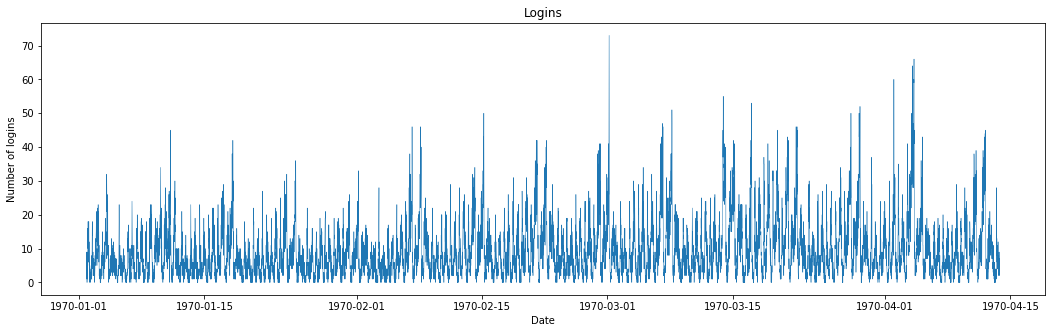

In [14]:
# Plot the frequency of logins over time
plt.figure(figsize=(18,5))
plt.plot(s2, linewidth=0.5)
plt.title('Logins')
plt.xlabel('Date')
plt.ylabel('Number of logins')

There seems to be a weekly pattern where the maximum number of logins occurs about every 7 days.

In [15]:
# View dates and times where number of logins are > 40
s2[s2 > 40]

1970-01-11 04:45:00    45
1970-01-18 04:15:00    42
1970-02-07 04:30:00    46
1970-02-08 03:15:00    46
1970-02-15 04:00:00    43
                       ..
1970-04-05 04:00:00    43
1970-04-05 04:15:00    42
1970-04-12 03:15:00    43
1970-04-12 04:00:00    44
1970-04-12 04:45:00    45
Length: 75, dtype: int64

In [16]:
# Day of week for logins > 40. 0=Monday, 6=Sunday
dow = [ts.dayofweek for ts in s2[s2 > 40].index]
#print(dow)


In [17]:
dow_dict = {0:'Mon', 1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'}

In [18]:
dow_dict[6]

'Sun'

In [19]:
dow_names = [dow_dict[x] for x in dow]
counter = Counter(dow_names)
counter

Counter({'Sun': 33, 'Sat': 29, 'Fri': 8, 'Tues': 2, 'Wed': 2, 'Thurs': 1})

In [20]:
cats = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
dow_df = pd.DataFrame(dow_names).astype('category', categories=cats, ordered=True)

In [21]:
dow_df.columns = ['day']

(array([33., 29.,  8.,  0.,  2.,  2.,  1.]),
 array([0.        , 0.71428571, 1.42857143, 2.14285714, 2.85714286,
        3.57142857, 4.28571429, 5.        ]),
 <a list of 7 Patch objects>)

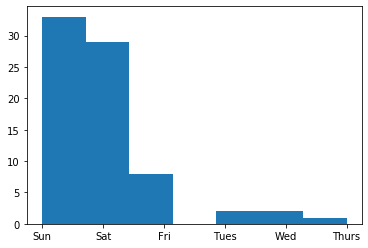

In [22]:
plt.hist(dow_names, bins=7)

The greatest number of logins occur on Saturdays and Sundays. The logins are at least three times greater on the weekend than on the weekdays.

Text(0, 0.5, 'Number of logins')

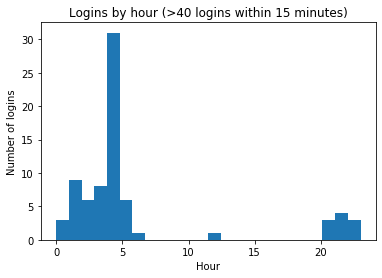

In [23]:
plt.hist(s2[s2 > 40].index.hour, bins=24)
plt.title('Logins by hour (>40 logins within 15 minutes)')
plt.xlabel('Hour')
plt.ylabel('Number of logins')

When logins are the most frequent (>40 logins within 15 minutes), they often happen between 10PM and 5AM.

# Part 3: Predictive Modeling

In [24]:
with open('ultimate_data_challenge.json', 'r') as read_file:
    data = json.load(read_file)

In [25]:
type(data)

list

In [26]:
data[:10]

[{'city': "King's Landing",
  'trips_in_first_30_days': 4,
  'signup_date': '2014-01-25',
  'avg_rating_of_driver': 4.7,
  'avg_surge': 1.1,
  'last_trip_date': '2014-06-17',
  'phone': 'iPhone',
  'surge_pct': 15.4,
  'ultimate_black_user': True,
  'weekday_pct': 46.2,
  'avg_dist': 3.67,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 0,
  'signup_date': '2014-01-29',
  'avg_rating_of_driver': 5.0,
  'avg_surge': 1.0,
  'last_trip_date': '2014-05-05',
  'phone': 'Android',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 50.0,
  'avg_dist': 8.26,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 3,
  'signup_date': '2014-01-06',
  'avg_rating_of_driver': 4.3,
  'avg_surge': 1.0,
  'last_trip_date': '2014-01-07',
  'phone': 'iPhone',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 100.0,
  'avg_dist': 0.77,
  'avg_rating_by_driver': 5.0},
 {'city': "King's Landing",
  'trips_in_fir

In [27]:
df = pd.DataFrame(data)

In [28]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [30]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Text(0.5, 1.0, 'Trips in the first 30 days')

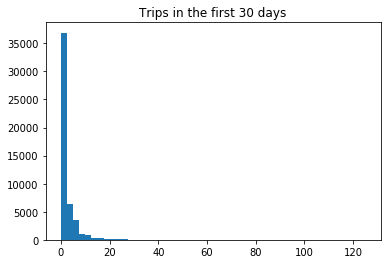

In [31]:
plt.hist(df.trips_in_first_30_days, bins=50)
plt.title('Trips in the first 30 days')

Many download the app and never use it.

In [32]:
type(df.last_trip_date)

pandas.core.series.Series

In [33]:
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)

In [34]:
last_trips = df['last_trip_date']

In [35]:
last_trips_s = pd.Series(range(len(last_trips)), index=last_trips)

In [36]:
last_trips_s

last_trip_date
2014-06-17        0
2014-05-05        1
2014-01-07        2
2014-06-29        3
2014-03-15        4
              ...  
2014-06-05    49995
2014-01-25    49996
2014-05-22    49997
2014-01-15    49998
2014-04-20    49999
Length: 50000, dtype: int64

In [37]:
# Count the number of people by last trip date
last_trips_s.resample('1D').count()

last_trip_date
2014-01-01     128
2014-01-02     180
2014-01-03     128
2014-01-04     199
2014-01-05     270
              ... 
2014-06-27    1120
2014-06-28    1679
2014-06-29    2036
2014-06-30    1408
2014-07-01     548
Freq: D, Length: 182, dtype: int64

Text(0.5, 1.0, 'Date of last trip')

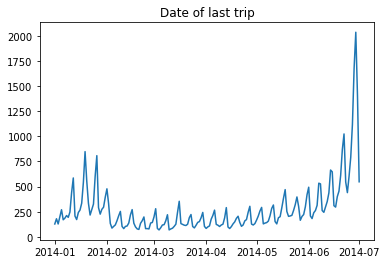

In [38]:
# Plot count of last trip dates
plt.plot(last_trips_s.resample('1D').count())
plt.title('Date of last trip')

In [39]:
last_trips_s.resample('1D').count()[-5:]

last_trip_date
2014-06-27    1120
2014-06-28    1679
2014-06-29    2036
2014-06-30    1408
2014-07-01     548
Freq: D, dtype: int64

The last day within this dataset is July 1, 2014.

## Data Preprocessing

In [40]:
# Create boolean column for "active" users (if they have taken a trip in the last 30 days)
df['active'] = last_trips > pd.to_datetime('2014-05-31')

In [41]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [42]:
# How many users are still active?
n_active = len(df[df.active == True])
n_active

18804

In [43]:
# Total number of users during this timeframe?
n_total = len(df)
n_total

50000

In [44]:
# Total fraction of users still active
print('The fraction of users still active is:', n_active/n_total)

The fraction of users still active is: 0.37608


In [45]:
# Create dataframe for predictors
X = df.drop(['last_trip_date', 'signup_date', 'active'], 1)
X.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9


In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(2)
memory usage: 3.5+ MB


In [47]:
# Check columnns that are missing data
print(len(X[X['phone'].isnull()])/len(X))
print(X['phone'].unique())

0.00792
['iPhone' 'Android' None]


There is only 0.8% of users that do not use either an iPhone or Android, and these null values were labeled with '0'.

In [48]:
# Replace null values with string '0'
X['phone'].fillna('0', inplace=True)

In [49]:
print(len(X[X['avg_rating_by_driver'].isnull()])/len(X))
print(X['avg_rating_by_driver'].unique())

0.00402
[5.  4.9 4.  3.  4.8 4.7 4.5 4.2 nan 4.4 4.6 3.7 4.3 3.5 2.  3.8 2.5 4.1
 3.9 1.  3.3 3.4 3.6 3.2 2.3 2.8 1.5 2.7]


There is only 0.4% of users that are not rated by their driver, so it is okay to fill nan values with an average rating.

In [50]:
# Fill with the mean of ratings
avg_rating = round(np.mean(X['avg_rating_by_driver']),1) #4.8 in this case
X['avg_rating_by_driver'].fillna(avg_rating, inplace=True)

In [51]:
print(len(X[X['avg_rating_of_driver'].isnull()])/len(X))
X[X['avg_rating_of_driver'].isnull()]


0.16244


,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,NaN,1.0,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,NaN,1.0,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,NaN,1.0,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,NaN,1.0,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,NaN,1.0,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,NaN,1.0,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,NaN,1.0,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,NaN,1.0,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,NaN,1.0,iPhone,0.0,False,0.0,0.00,4.0


16.2% of users did not have avg driver rating. It would be interesting to have a predictor for users who do not rate their driver.

In [52]:
# Create new boolean column 'no_driver_rating'
X['no_driver_rating'] = X['avg_rating_of_driver'].isnull()


In [53]:
print('Mean:', np.nanmean(X['avg_rating_of_driver']))
print('Median:', np.nanmedian(X['avg_rating_of_driver']))
print('Unique values:', X['avg_rating_of_driver'].unique())

Mean: 4.601559291274655
Median: 4.9
Unique values: [4.7 5.  4.3 4.6 4.4 3.5 nan 4.5 4.  3.9 4.9 4.8 2.5 3.7 1.  4.1 4.2 3.
 3.8 2.  2.7 3.3 2.8 3.6 3.4 3.2 2.6 3.1 2.9 1.7 1.8 1.5 2.3 1.9 2.1 2.4
 1.6 2.2]


In [54]:
# Fill missing values with a rating of 3 - because this represents a review that is neither positive or negative
X['avg_rating_of_driver'].fillna(3.0, inplace=True)

In [55]:
# Set y (outcome/target) = active column
y = df['active']
y.head()

0     True
1    False
2    False
3     True
4    False
Name: active, dtype: bool

In [56]:
# Print out shape of X and y dataframes
print(X.shape, y.shape)

(50000, 11) (50000,)


In [57]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
no_driver_rating          50000 non-null bool
dtypes: bool(2), float64(6), int64(1), object(2)
memory usage: 3.5+ MB


## Create the Model

In [58]:
# Separate categorical and numerical features for pre-processing
cat_cols = X.select_dtypes(include=['object', 'bool']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [59]:
cat_cols

Index(['city', 'phone', 'ultimate_black_user', 'no_driver_rating'], dtype='object')

In [60]:
num_cols

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'],
      dtype='object')

In [61]:
# Transform categorical data with OneHotEncoder, and numerical data with MinMaxScaler
col_transform = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), cat_cols), 
    ('scaler', MinMaxScaler(), num_cols)])

In [62]:
lrModel = LogisticRegression(penalty='l1', random_state=0) # Regularization: L1 penalty = Lasso

In [63]:
pipeline = Pipeline(steps=[('preprocessor', col_transform), 
                           ('classifier', lrModel)])

In [64]:
# 5-Fold Cross Validation
cv = KFold(n_splits=5, shuffle=True, random_state=50)

In [65]:
scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)

In [66]:
# Accuracy scores for the 5-fold cross validation
print(scores)

[0.7187 0.7135 0.7271 0.7267 0.7263]


In [67]:
# Average accuracy score +- standard deviation
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.722 (0.005)


To view the coefficients of the logistic regression, we can manually get the dummies for categorical data.

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
no_driver_rating          50000 non-null bool
dtypes: bool(2), float64(6), int64(1), object(2)
memory usage: 3.5+ MB


In [69]:
cat_cols

Index(['city', 'phone', 'ultimate_black_user', 'no_driver_rating'], dtype='object')

In [70]:
X_new = X # copy of X

In [71]:
for var in cat_cols:
    prefix_name ='var'+'_'+var
    dummies = pd.get_dummies(X[var], prefix=prefix_name)
    X_new=X_new.join(dummies)

In [72]:
X_new.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,...,var_city_Astapor,var_city_King's Landing,var_city_Winterfell,var_phone_0,var_phone_Android,var_phone_iPhone,var_ultimate_black_user_False,var_ultimate_black_user_True,var_no_driver_rating_False,var_no_driver_rating_True
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,...,0,1,0,0,0,1,0,1,1,0
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,...,1,0,0,0,1,0,1,0,1,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,...,1,0,0,0,0,1,1,0,1,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,...,0,1,0,0,0,1,0,1,1,0
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,...,0,0,1,0,1,0,1,0,1,0


In [73]:
# Remove the columns that now have dummies
data_vars=X_new.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_cols]

In [74]:
len(to_keep)

17

In [75]:
X_final = X_new[to_keep]
X_final.columns.values

array(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
       'var_city_Astapor', "var_city_King's Landing",
       'var_city_Winterfell', 'var_phone_0', 'var_phone_Android',
       'var_phone_iPhone', 'var_ultimate_black_user_False',
       'var_ultimate_black_user_True', 'var_no_driver_rating_False',
       'var_no_driver_rating_True'], dtype=object)

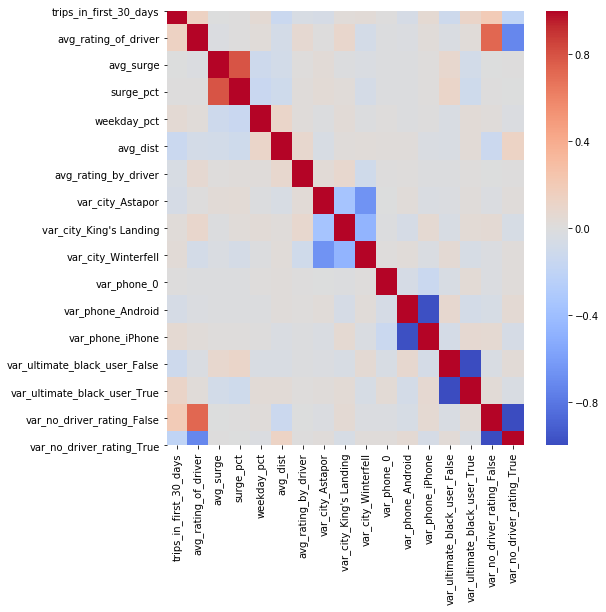

In [76]:
# Correlation of variables
plt.figure(figsize=(8,8))
sns.heatmap(X_final.corr(), cmap='coolwarm')

Because of multicollinearity of avg_surge and surge_pct, will remove surge_pct. 

In [77]:
X_final = X_final.drop(['surge_pct'], axis=1)
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
trips_in_first_30_days           50000 non-null int64
avg_rating_of_driver             50000 non-null float64
avg_surge                        50000 non-null float64
weekday_pct                      50000 non-null float64
avg_dist                         50000 non-null float64
avg_rating_by_driver             50000 non-null float64
var_city_Astapor                 50000 non-null uint8
var_city_King's Landing          50000 non-null uint8
var_city_Winterfell              50000 non-null uint8
var_phone_0                      50000 non-null uint8
var_phone_Android                50000 non-null uint8
var_phone_iPhone                 50000 non-null uint8
var_ultimate_black_user_False    50000 non-null uint8
var_ultimate_black_user_True     50000 non-null uint8
var_no_driver_rating_False       50000 non-null uint8
var_no_driver_rating_True        50000 non-null uint8
dtypes: float64(5

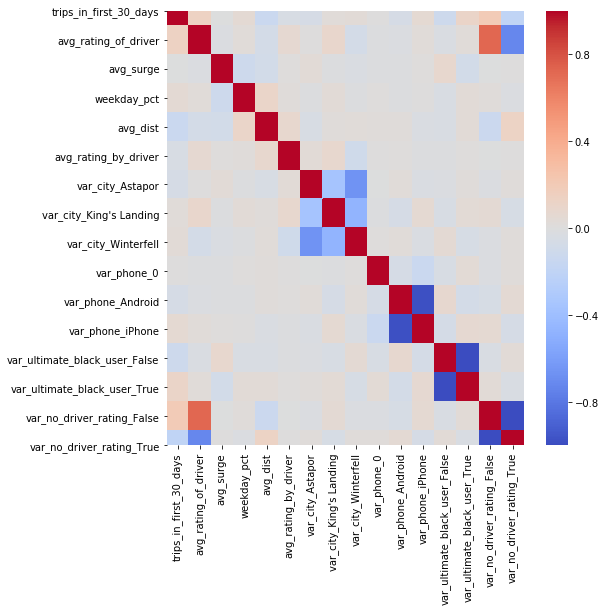

In [78]:
# Look at correlation heatmap again
plt.figure(figsize=(8,8))
sns.heatmap(X_final.corr(), cmap='coolwarm')

In [79]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=0)
X_train.shape

(40000, 16)

In [80]:
# Feature extraction
model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

C:\Users\chant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Num Features: 5
Selected Features: [False False False False False False  True  True False False  True False
  True False False  True]
Feature Ranking: [ 8  9  7 12 10  5  1  1  6 11  1  2  1  4  3  1]


In [81]:
# Confusion matrix
y_pred = rfe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5404  847]
 [2053 1696]]


In [82]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(rfe.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.71


In [83]:
X_final.columns[fit.support_]

Index(['var_city_Astapor', 'var_city_King's Landing', 'var_phone_Android',
       'var_ultimate_black_user_False', 'var_no_driver_rating_True'],
      dtype='object')

In [84]:
# Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_final,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [85]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_final,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [86]:
results = pd.DataFrame({'feature':X_final.columns.values, 'ridge_coefficients':ridge.coef_})
results

,feature,ridge_coefficients
0,trips_in_first_30_days,0.018085
1,avg_rating_of_driver,-0.011924
2,avg_surge,0.018059
3,weekday_pct,-0.000082
4,avg_dist,-0.005577
5,avg_rating_by_driver,-0.030824
6,var_city_Astapor,-0.146283
7,var_city_King's Landing,0.199132
8,var_city_Winterfell,-0.052849
9,var_phone_0,-0.010723


In [87]:
# Positive coefficients
greatest_coefs = sorted(ridge.coef_, reverse=True)[:5]
for coef in greatest_coefs:
    print(results[results.ridge_coefficients==coef])

                   feature  ridge_coefficients
7  var_city_King's Landing            0.199132
             feature  ridge_coefficients
11  var_phone_iPhone            0.102438
                         feature  ridge_coefficients
13  var_ultimate_black_user_True              0.0847
                       feature  ridge_coefficients
14  var_no_driver_rating_False            0.071373
                  feature  ridge_coefficients
0  trips_in_first_30_days            0.018085


In [88]:
# Negative coefficients
neg_coefs = sorted(ridge.coef_)[:5]
for coef in neg_coefs:
    print(results[results.ridge_coefficients==coef])

            feature  ridge_coefficients
6  var_city_Astapor           -0.146283
              feature  ridge_coefficients
10  var_phone_Android           -0.091714
                          feature  ridge_coefficients
12  var_ultimate_black_user_False             -0.0847
                      feature  ridge_coefficients
15  var_no_driver_rating_True           -0.071373
               feature  ridge_coefficients
8  var_city_Winterfell           -0.052849


In [89]:
# Statsmodel coefficients
logit_model=sm.Logit(y, X_final)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.552349
         Iterations 6


C:\Users\chant\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\chant\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\chant\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\chant\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                                      Results: Logit
Model:                       Logit                    Pseudo R-squared:         0.166     
Dependent Variable:          active                   AIC:                      55260.8817
Date:                        2020-04-21 08:51         BIC:                      55375.5388
No. Observations:            50000                    Log-Likelihood:           -27617.   
Df Model:                    12                       LL-Null:                  -33106.   
Df Residuals:                49987                    LLR p-value:              0.0000    
Converged:                   1.0000                   Scale:                    1.0000    
No. Iterations:              6.0000                                                       
------------------------------------------------------------------------------------------
                               Coef.    Std.Err.     z     P>|z|     [0.025       0.975]  
-------------------------------------